## LSTM with plain tensorflow

In [1]:
import tensorflow as tf
from tensorflow.python.ops import gen_array_ops
from tensorflow.python.ops import array_ops
from sklearn.model_selection import train_test_split 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def sin(x, T=100):
    return np.sin(2.0*np.pi*x/T)

In [3]:
x = np.array([1,2,3,4,5])
sin(x)

array([0.06279052, 0.12533323, 0.18738131, 0.24868989, 0.30901699])

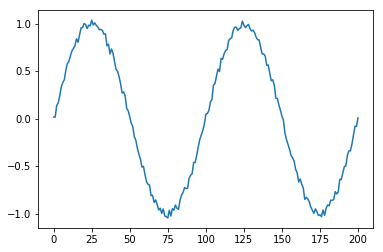

In [4]:
def toy_problem(T=100, ampl=0.05): 
    x = np.arange(0, 2*T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x)) 
    return sin(x) + noise

T=100
f = toy_problem(T)
x=np.arange(0, 2*T + 1)
plt.plot(x, f)

In [5]:
length_of_sequences = 2*T
maxlen = 25

data = []
target = []

for i in range(0, length_of_sequences - maxlen +1): 
    data.append(f[i:i+maxlen]) 
    target.append(f[i+maxlen])

In [6]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [7]:
N_train = int(len(data)*0.9)
N_validation = len(data)-N_train
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

## Tensorflow


In [13]:
tf.reset_default_graph()
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None, n_in=None):        
    def weight_variable(shape):          #Weight function 
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
    def bias_variable(shape):            #Bias function
        return tf.Variable(tf.zeros(shape))
    
    #Initialize State
    init_state = tf.truncated_normal(shape=(n_batch, 2*n_hidden), stddev=0.01) 
    state=init_state
    
    outputs = []    # 가장 마지막 것들만 저장할 output
    
    #Weights of the last state(n_in을 받음)
    Ws = tf.get_variable('Ws', shape=(n_in, 4*n_hidden), initializer=tf.contrib.layers.xavier_initializer(), 
                         dtype=tf.float32)
    #Weights of the hidden state 
    Wh = tf.get_variable('Wh', shape=(n_hidden, 4*n_hidden), initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    #Bias of the network
    bh = tf.get_variable('bh', shape=(1, 4*n_hidden), initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    
    for t in range(maxlen):
        # c : hidden state, h : state 
        #c, h = gen_array_ops.split(axis=1, num_split=2, value=state)
        c, h = array_ops.split(axis=1, num_or_size_splits=2, value=state)
        
        concate = (tf.matmul(x[:, t, :],Ws) + tf.matmul(h,Wh) + bh)

        # i = input_gate, j = new_input, f = forget_gate, o = output_gate 
        #i, j, f, o = gen_array_ops.split(axis=1, num_split=4, value=concate)
        i, j, f, o = array_ops.split(axis=1, num_or_size_splits=4, value=concate)
        
        # new_c : new hidden state, new_h : new state
        new_c = (c * tf.sigmoid(f + 1) + tf.sigmoid(i) *  tf.nn.relu(j))
        new_h = tf.nn.relu(new_c) * tf.sigmoid(o)
        
        #state = gen_array_ops.concat(1, [new_c, new_h])
        state = array_ops.concat([new_c, new_h],1)
        outputs.append(state)
    
    output = outputs[-1]
    V = weight_variable([2*n_hidden, n_out])
    b = bias_variable([n_out])
    y = tf.matmul(output, V) + b      #final y 
    return y

In [14]:
X[:,1,:].shape

(176, 1)

In [16]:
n_in = 1
n_hidden = 50
n_out = 1
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in]) 
t = tf.placeholder(tf.float32, shape=[None, n_out]) 
n_batch = tf.placeholder(tf.int32, shape=[])
y = inference(x,  n_batch=n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out, n_in=n_in)

In [17]:
## Loss function
def loss(y, t):
    mse = tf.reduce_mean(tf.square(y-t))
    return mse

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999) 
    train_step = optimizer.minimize(loss)
    return train_step

loss = loss(y,t)
train_step = training(loss)

In [18]:
## Training
from sklearn.utils import shuffle

epochs = 1000
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size 
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train) 
    
    for i in range(n_batches):
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train_step, feed_dict={
        x: X_[start:end],
        t: Y_[start:end],
        n_batch: batch_size
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    
    my_loss.append(val_loss)
    
    if (epoch %100 == 0) :
        print("epoch:", epoch, "validation loss:", val_loss)

epoch: 0 validation loss: 0.43829358
epoch: 100 validation loss: 0.0065502846
epoch: 200 validation loss: 0.0016292734
epoch: 300 validation loss: 0.0013736805
epoch: 400 validation loss: 0.0013832782
epoch: 500 validation loss: 0.0013618933
epoch: 600 validation loss: 0.0014775431
epoch: 700 validation loss: 0.0024218154
epoch: 800 validation loss: 0.002348496
epoch: 900 validation loss: 0.0017850788


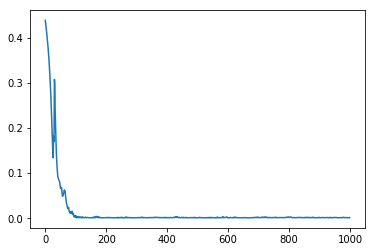

In [19]:
plt.plot(my_loss)

In [20]:
#maxlen = 자료길이

original = [f[i] for i in range(maxlen)] 
predicted = [None for i in range(maxlen)]

Z=X[:1]
for i in range(length_of_sequences - maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1 
    })
    
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))
    

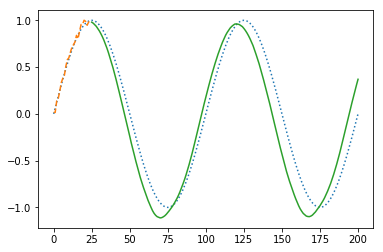

In [21]:
plt.plot(toy_problem(T=100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)